In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import MDS
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.io import output_notebook
from bokeh.models import PrintfTickFormatter
from sklearn import mixture
from scipy.stats import norm

sns.set(style="darkgrid")

def proportion(labels, bins):
    """ Given array of labels return a vector of corresponding proportions """
    proportions = np.zeros(len(bins))
    binInd,counts = np.unique(labels, return_counts=True)
    proportions[binInd-1] = counts / counts.sum()
    return proportions

def fitData(freqVec, components=2):
    """ Fit provided data and return the Gaussian Mixture Model """
    freqVec = freqVec.reshape(-1,1)
    gmm = mixture.GaussianMixture(components, max_iter=100, n_init=1)
    # gmm = mixture.GaussianMixture(components, max_iter=100, n_init=3, means_init=[[10],[80]])
    gmm.fit(freqVec)
    return gmm

def plotHist(freqVec, gmm):
    """ Plot the histogram and computed cdfs used for classification"""
    # Get estimated MLE and weights to build component pdfs
    means = gmm.means_.flatten()
    stdDiv = np.sqrt(gmm.covariances_.flatten())
    weights = gmm.weights_.flatten()


    plt.figure(figsize=(20, 15))
    split= [int(mean) for mean in means]
    title1 = 'Alternative strain splits {} (log scale) '.format(split)
    title2 = 'Alternative strain splits {} (lin scale) '.format(split)
    title3 = 'GMM model pdf'

    fig1 = plt.subplot(311)

    numBins = 100
    plt.hist(freqVec, bins=numBins, range=(0,numBins))
    plt.yscale('log',basey=2,nonposy='clip')
    plt.title(title1)
    plt.ylabel("number of positions")
    plt.xticks(range(0, numBins+1, 10))


    fig2 = plt.subplot(312)
    plt.hist(freqVec, bins=numBins, range=(0,numBins), label='Proportion (lin scale)')
    plt.xticks(range(0,numBins+1 ,10))
    plt.title(title2)

    # Plot GMM pdf
    fig3 = plt.subplot(313)
    plt.title(title3)
    x_axis = np.arange(0,numBins+1, 0.5).reshape(-1,1)

    plt.plot(x_axis, np.exp(gmm.score_samples(x_axis))) # compute log likelyhood of each sample
#     plt.savefig(outputDir + figureFileName)
    plt.show()

In [2]:
f1 = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_data/output/2_10/freqVec.filter.csv'
f2 = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_data/output/24_10/freqVec.filter.csv'
f3 = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_data/output/5_10/freqVec.filter.csv'
f4 = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_data/output/29_10/freqVec.filter.csv'
f5 = '/home/user1/Documents/lab/DrugResistance/splitStrains/data/mixed_data/output/4_10/freqVec.filter.csv'
sampleId = [2, 24, 5, 29, 4]
fileList = [f1, f2, f3, f4, f5]

freqVecList = []
freqVecListFilt = []
# load files
for fi in fileList:
    freqVecList.append(np.loadtxt(open(fi, "r"), delimiter=","))

# compute filtered list
for freqVec in freqVecList:
    freqVecFilt = []
    
    for a in freqVec:
        if a[0:4].max() < 95:
            freqVecFilt.append(a)
    freqVecListFilt.append(np.array(freqVecFilt))
freqVecList = freqVecListFilt

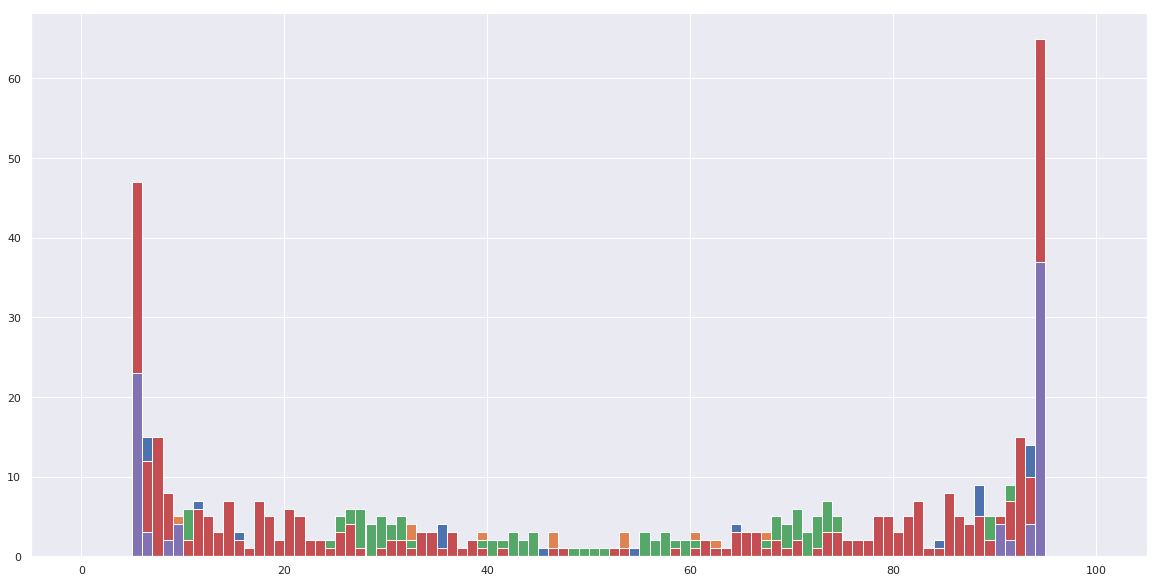

In [3]:
plt.figure(figsize = (20,10))

for freq in freqVecList:
    freqVecFlat = freq.flatten()
    freqVecFlat = freqVecFlat[freqVecFlat > 5]
    plt.hist(freqVecFlat, bins=100, range=(0,100), label='Proportion (lin scale)')

# plt.legend(sampleId)
plt.show()

In [4]:
dataList = []
for freqVec in freqVecList:
    dataPoints = []
    for a in freqVec:
        for v in a[0:-1]:
            dataPoints.append([a[4],v])
    dataPoints = np.array(dataPoints, dtype=int)
    dataList.append(dataPoints)

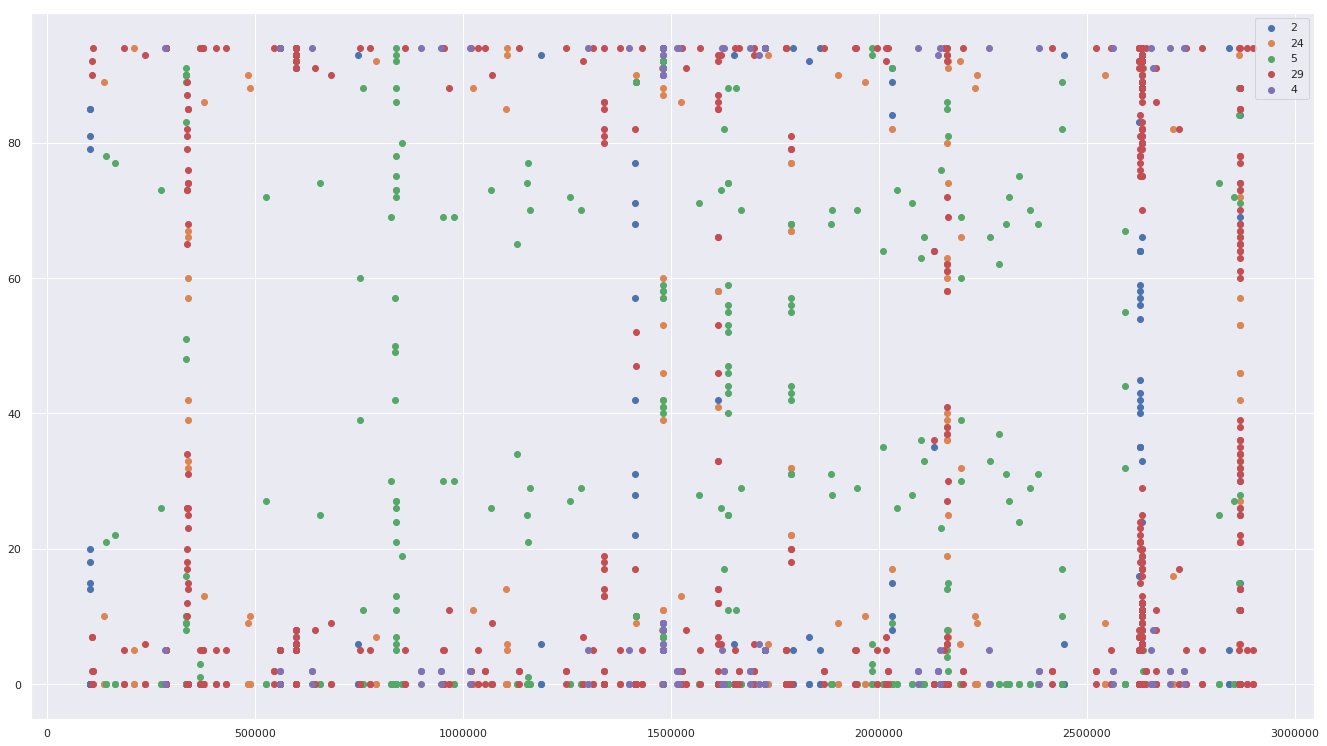

In [5]:
plt.figure(figsize = (23,13))
for dataPoints in dataList:
    plt.scatter(dataPoints[:,0], dataPoints[:,1])

plt.legend(sampleId)
plt.show()

In [6]:
# estimate global proportions for each bin
id = 0
freqVec = freqVecList[id]
bins=np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
labels = np.digitize(freqVec[:,0:4].flatten(), bins)    # returns the indices of bins for each element
globalProportions = proportion(labels, bins)    # compute proportion of each bin

# calculate entropies for ploting
entropyData = []
step = 1
for i in range(0,len(freqVec),step):
    intervalVec = freqVec[i:i+step]
    interval_labels = np.digitize(intervalVec[:,0:4].flatten(), bins)    # returns the indices of bins for each element
    values, count = np.unique(interval_labels,return_counts=True)
    entropy = -(globalProportions.take(values-1) * np.log2(globalProportions.take(values-1))).sum()
    pos = int(freqVec[i,4])
    entropyData.append([pos, entropy])
entropyData = np.array(entropyData)
entropyMean = entropyData[:,1].mean()
print(labels, globalProportions)


[ 1  9  2  1  2  1  1  9  1  8  1  3  2  1  1  9 10  1  1  1  1  1 10  1
  1  1 10  1  1  1 10  1 10  1  1  1  1  1  1 10 10  1  1  1  1  1 10  1
  1  1 10  1 10  1  1  1  1 10  1  1 10  1  1  1  1 10  1  1  1 10  1  1
  3  8  1  1  3  1  8  1  1  7  4  1  1  6  5  1  1  5  6  1  1  1  1 10
  1  1 10  1  1  1 10  1  1  1 10  1  1  1  1 10  1 10  1  1  1 10  1  1
  1  1 10  1  1  1 10  1  1  1  1 10  1  1  9  2  9  1  1  2  7  1  1  4
  1  1 10  1  2  9  1  1  1  4  1  7  1  4  1  7  5  1  1  6  1  5  1  6
  5  1  1  6  6  1  1  5  5  1  1  6  7  4  1  1  1 10  1  1  1  9  1  2
  1  2  9  1  1  2  9  1  2  1  1  9  4  1  1  7  8  1  1  3  2  1  1  9
  1  1  9  2  1  9  1  2  1  2  1  9  1  9  1  2  1  2  1  9 10  1  1  1
  1 10  1  1  1 10  1  1  1  1  1 10  1 10  1  1  1  1  1 10  1  1 10  1
 10  1  1  1  1 10  1  1  1  1  9  2  2  1  1  9  9  1  1  2  9  1  1  2
  1  2  1  9 10  1  1  1  1  7  1  4  2  9  1  1  8  3  1  1  7  1  1  4
  1  2  1  9  1  2  9  1  1  9  1  2] [0.61111111 0

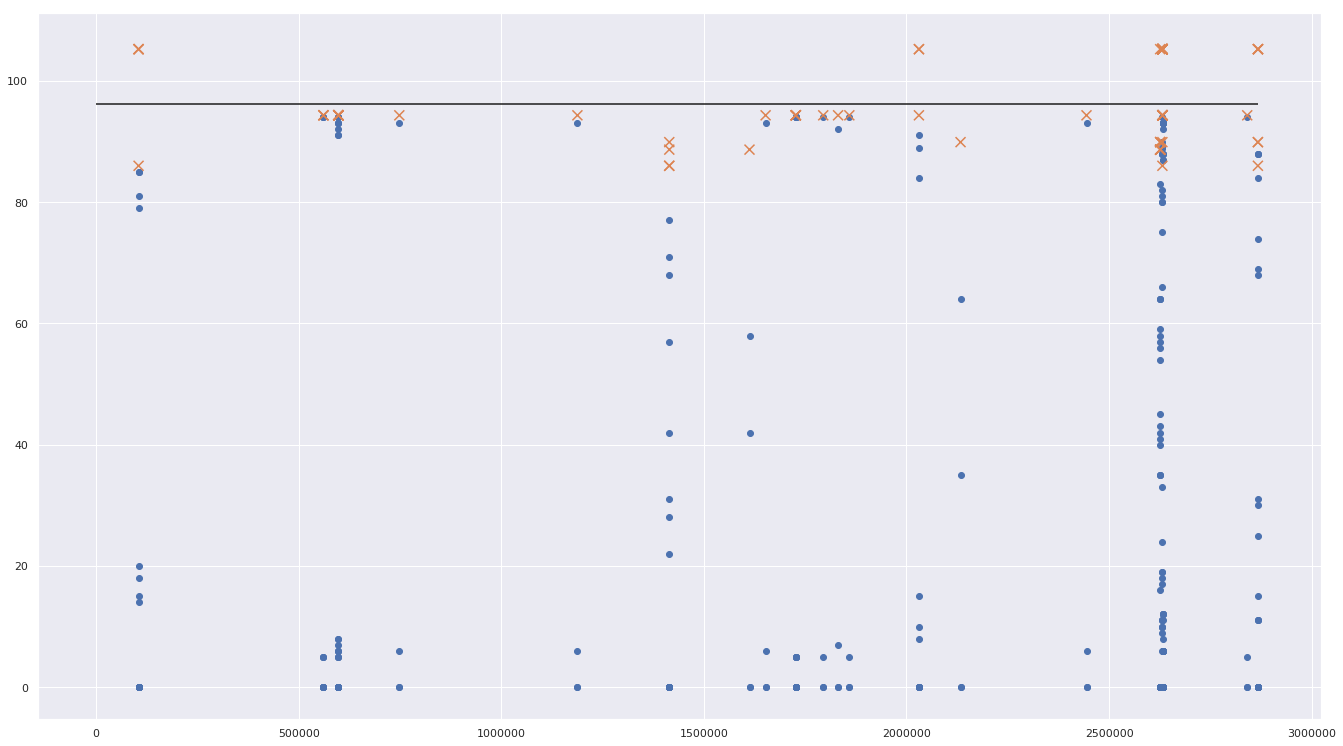

In [7]:
plt.figure(figsize = (23,13))
plt.scatter(dataList[id][:,0], dataList[id][:,1])
scaledEntropyMean = 50*entropyMean+55
sizes = 100* np.ones(len(entropyData))
plt.scatter(entropyData[:,0], 50*entropyData[:,1]+55, marker='x',s=sizes )
plt.hlines(scaledEntropyMean, 0, entropyData[-1])
plt.show()

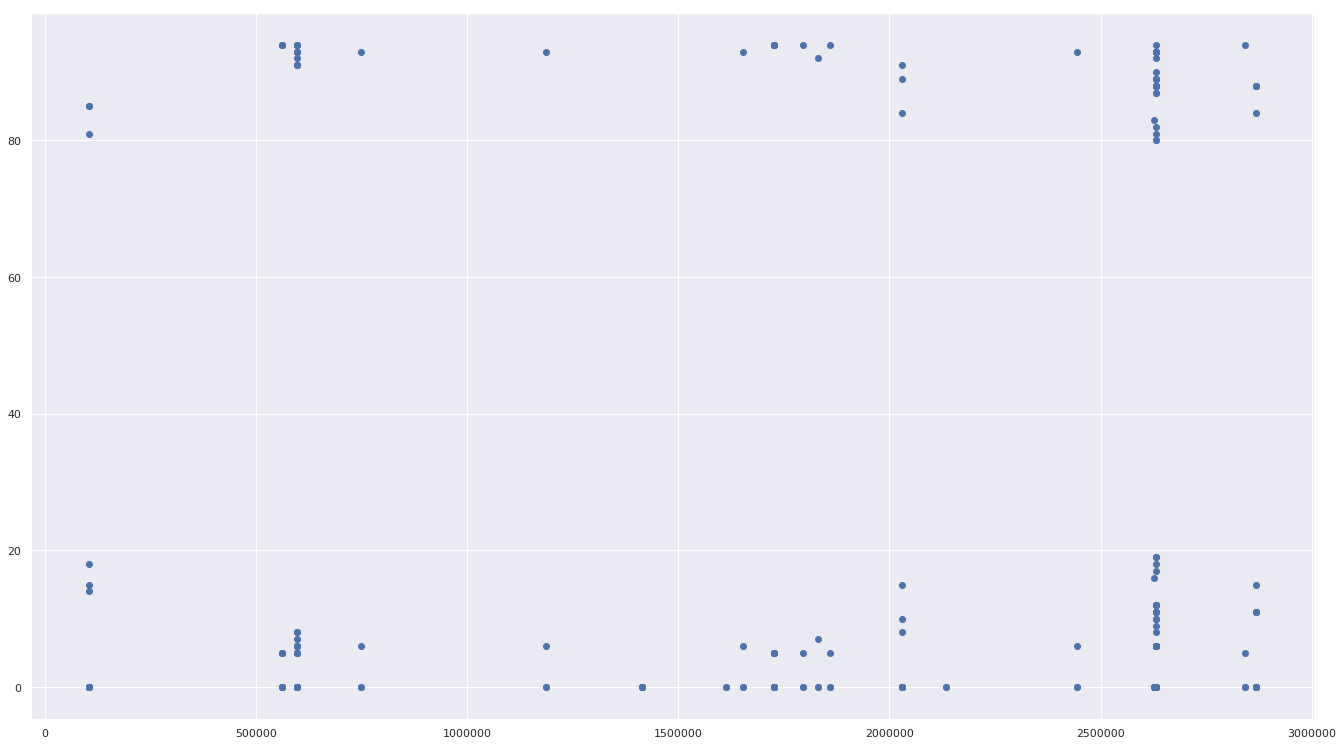

[105006, 105006, 1414620, 1414620, 1414628, 1414628, 1414652, 1414652, 1414718, 1414718, 1612647, 1612647, 2133474, 2133474, 2626243, 2626243, 2626246, 2626246, 2626270, 2626270, 2626273, 2626273, 2626279, 2626279, 2626282, 2626282, 2626287, 2626287, 2626294, 2626294, 2631598, 2631598, 2631619, 2631619, 2867206, 2867206, 2867332, 2867332, 2867346, 2867346]


In [8]:
efilter = 0.6
dataPoints = dataList[id]
dataPointsFilt = []
badPositions = []
for i, point in enumerate(dataPoints):
    label = np.digitize(point[1],bins)    # returns the indices of bins for each element
    entropy = -(globalProportions.take(label-1) * np.log2(globalProportions.take(label-1))).sum()
#     print('proportion:', point[1], 'label: ', label, 'entropy:', entropy, 'mean: ', entropyMean)
    if abs(entropy - entropyMean) < efilter:
        dataPointsFilt.append(point)
    else:
        badPositions.append(point[0])

dataPointsFilt = np.array(dataPointsFilt)
plt.figure(figsize = (23,13))
plt.scatter(dataPointsFilt[:,0], dataPointsFilt[:,1])
plt.show()
print(badPositions)

means: [12.45462529 87.54537471  6.09517133 93.90482867]


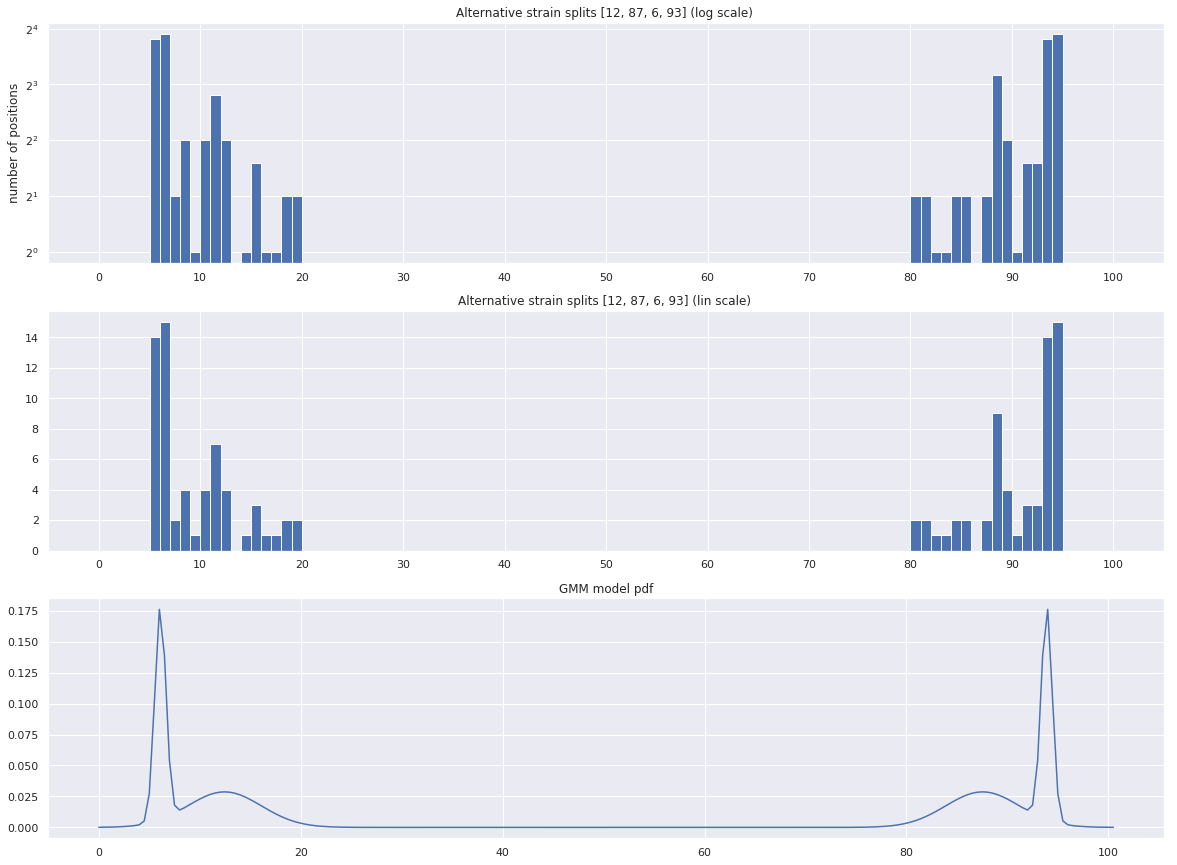

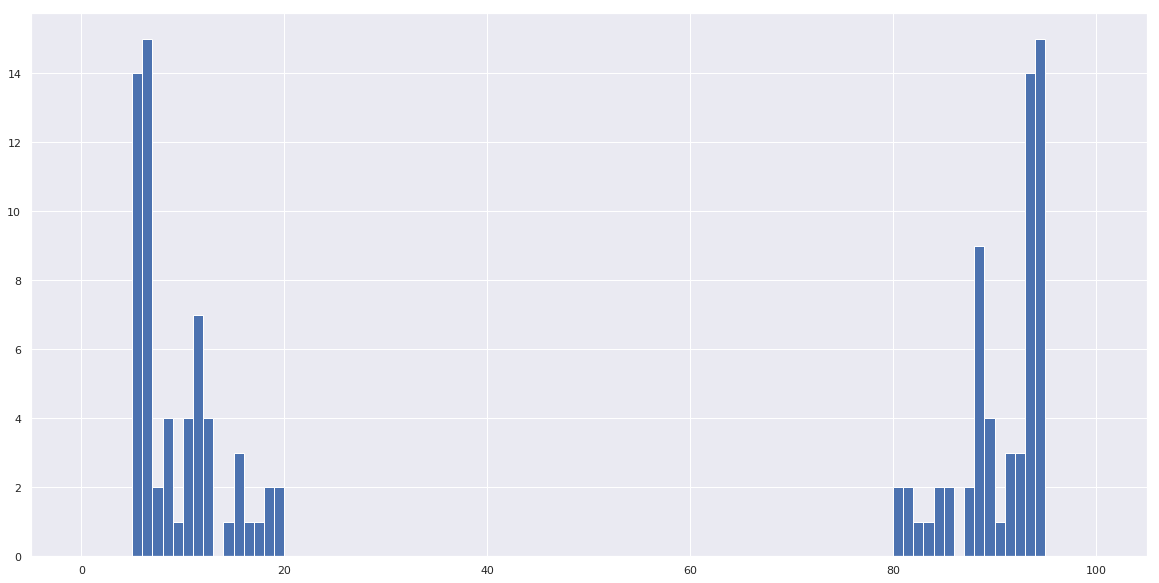

In [9]:
freqVec = freqVec[:,0:4]
freqVecFlat = freqVec.flatten()
freqVecFlatFilt = []

for value in freqVecFlat:
    label = np.digitize(value,bins)    # returns the indices of bins for each element
    entropy = -(globalProportions.take(label-1) * np.log2(globalProportions.take(label-1))).sum()
    
    if abs(entropy - entropyMean) < efilter:
        freqVecFlatFilt.append(value)

freqVecFlatFilt = np.array(freqVecFlatFilt)
freqVecFlatFilt = freqVecFlatFilt[freqVecFlatFilt > 5]
freqVecFlat = freqVecFlat[freqVecFlat > 5]

gmm = fitData(freqVecFlatFilt, 4)
print("means:", gmm.means_.flatten())

plotHist(freqVecFlatFilt, gmm)

plt.figure(figsize = (20,10))

# plt.hist(freqVecFlat, bins=100, range=(0,100))
plt.hist(freqVecFlatFilt, bins=100, range=(0,100))
# plt.legend(['removed noise', 'cleaned sample'])
plt.show()